# Custom preprocessing

Preprocessors in OpenSoundscape perform all of the preprocessing steps from loading a file from the disk up to providing a sample to the machine learning algorithm for training or prediction. These classes are used when (a) training a machine learning model in OpenSoundscape, or (b) making predictions with a machine learning model in OpenSoundscape. 

If you are already familiar with PyTorch, you might notice that Preprocessors take the place of, and are children of, PyTorch's Dataset classes to provide each sample to PyTorch as a Tensor.

Preprocessors are designed to be flexible and modular, so that each step of the preprocessing pipeline can be modified or removed. This notebook demonstrates:

- preparation of audio data to be used by a preprocessor
- how "Actions" are strung together into "Pipelines" to preprocess data
- modifying the parameters of actions
- turning Actions on and off
- modifying the order and contents of pipelines
- use of the `AudioToSpectrogramPreprocessor` class, including examples of:
    * modifying audio and spectrogram parameters
    * changing the output image shape
    * changing the output type
- use of the `CnnPreprocessor` class, including examples of:
    * choosing between default "augmentation on" and "augmentation off" pipelines
    * modifying augmentation parameters
    * using the "overlay" augmentation
- writing custom preprocessors and actions

First, import the needed packages.

In [54]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess

Set up plotting and some helper functions.

In [55]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# helper function for displaying a sample as an image 
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

Set manual seeds for pytorch and python. These ensure the training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [56]:
torch.manual_seed(0)
random.seed(0)

## Preparing audio data

### Download labeled audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [57]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

### Generate one-hot encoded labels 

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).


We manipulate the label dataframe to give "one hot" labels - that is, a column for every class, with 1 for present or 0 for absent in each sample's row. In this case, our classes are simply 'negative' for files without a woodcock and 'positive' for files with a woodcock.  Note that these classes are mutually exclusive, so we have a "single-target" problem (as opposed to a "multi-target" problem where multiple classes can simultaneously be present).

For more details on the steps below, see the basic CNN training and prediction tutorial.

In [58]:
#load Specky output: a table of labeled audio files
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
#update the paths to the audio files
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]

from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(specky_table[['woodcock']].values)
labels = pd.DataFrame(index=specky_table['filename'],data=one_hot_labels,columns=classes)
labels.head()

present  absent
filename                                                           
./woodcock_labeled_data/d4c40b6066b489518f8da83...        1       0
./woodcock_labeled_data/e84a4b60a4f2d049d73162e...        0       1
./woodcock_labeled_data/79678c979ebb880d5ed6d56...        1       0
./woodcock_labeled_data/49890077267b569e142440f...        1       0
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5...        1       0

## Intro to Preprocessors


Preprocessors prepare samples for use by machine learning algorithms by stringing together transformations called **Actions** into a **Pipeline**. The preprocessor sequentially applies to the sample each Action in the Pipeline. You can add, remove, and rearrange Actions from the pipeline and change the parameters of each Action.

The currently implemented Preprocessor classes and their Actions include:

- `CnnPreprocessor` - loads audio files, creates spectrograms, performs various augmentations, and returns a pytorch Tensor.
- `AudioToSpectrogramPreprocessor` - loads audio files, creates spectrograms, and returns a pytorch Tensor (no augmentation). 

### Initialize preprocessor 

A Preprocessor must be initialized with a very specific dataframe: 

- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

For example, we've set up the labels dataframe with files as the index and classes as the columns, so we can use it to make an instance of `CnnPreprocessor`:

In [59]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

preprocessor = CnnPreprocessor(labels)

### Access sample from a Preprocessor

A sample is accessed in a preprocessor using indexing, like a list. Each sample is a dictionary with two keys: 'X', the Tensor of the sample, and 'y', the Tensor of labels of the sample.

In [60]:
preprocessor[0]

{'X': tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0191, -0.0078,  0.0653],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0958,  0.0501,  0.0597],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3639,  0.1509,  0.0387],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ..., -0.0090, -0.0230,  0.0743],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1073,  0.0300,  0.0806],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3479,  0.1474,  0.0241],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0079, -0.0237,  0.0630],
          [ 0.0000,  0.

### Subset samples from a Preprocessor
Preprocessors allow you to select a subset of samples using `sample()` and `head()` methods (like Pandas DataFrames). For example:

In [61]:
len(preprocessor)

29

Select the first 10 samples (non-random)

In [62]:
len(preprocessor.head(5))

5

Randomly select an absolute number of samples

In [63]:
len(preprocessor.sample(n=10))

10

Randomly select a fraction of samples

In [64]:
len(preprocessor.sample(frac=0.5))

14

## Pipelines and actions

Each Preprocessor class has two attributes, `preprocessor.pipeline` and `preprocessor.actions`. Pipelines are comprised of Actions.

### About Pipelines

The preprocessor's Pipeline is the ordered list of Actions that the preprocessor performs on each sample. 

* The Pipeline is stored in the `preprocessor.pipeline` attribute.

* You can modify the contents or order of Preprocessor Actions by overwriting the preprocessor's `.pipeline` attribute. When you modify this attribute, you must provide a list of Actions, where each Action is an instance of a class that sub-classes `opensoundscape.preprocess.BaseAction`.

Inspect the current pipeline.

In [65]:
# inspect the current pipeline (ordered sequence of Actions to take)
preprocessor.pipeline

### About actions

Preprocessors come with a set of predefined Actions that are available to the preprocessor. These are not necessarily all included in the preprocessing pipeline; these are just the transformations that are available to be strung together into a pipeline if desired. 

* The Actions are stored in the `preprocessor.actions` attribute. Each Action is an instance of a class (described in more detail below).

* Each Action takes a sample (and its labels*), performs some transformation to them, and returns the sample (and its labels*). The code for this transformation is stored in the Action's `.go()` method.

* You can customize Actions using the `.on()` and `.off()` methods to turn the Action on or off, or by changing the action's parameters. Any customizable parameters for performing the Action are stored in a dictionary, `.params`. This dictionary can be modified using the Action's `.set()` method, e.g. `action.set(param=value, param2=value2, ...)`.

* You can view all the available Actions in a preprocessor using the `.list_actions()` method.

In [66]:
# create a new instance of a CnnPreprocessor
preprocessor = AudioToSpectrogramPreprocessor(labels)

# print all Actions that have been added to the preprocessor
# (Note that this is not the pipeline, just a collection of available actions)
preprocessor.actions.list_actions()

['load_audio',
 'trim_audio',
 'to_spec',
 'bandpass',
 'to_img',
 'to_tensor',
 'normalize']

Notice that the Actions in `preprocessor.actions.list_actions()` are not identical to the names listed in the pipeline, but are parallel. For example, in this case, `preprocessor.actions.to_spec` corresponds to an instance of `opensoundscape.preprocess.actions.AudioToSpectrogram`:

In [67]:
preprocessor.actions.to_spec

That's because of the structure of actions:

* The `.actions` attribute is an instance of a class called `ActionContainer` (see below)
* The `ActionContainer` has an attribute for each possible action, e.g. `preprocessor.actions.to_spec`
* Each attribute is defined as an instance of an Action class, e.g. `AudioToSpectrogram`
* Each Action class is a child of a class called `BaseAction`; see the `actions` module for examples.

In [68]:
preprocessor.actions?

Type:        ActionContainer
String form: <opensoundscape.preprocess.actions.ActionContainer object at 0x7fa99741d760>
File:        ~/Development/opensoundscape/opensoundscape/preprocess/actions.py
Docstring:  
this is a container object which holds instances of Action child-classes

the Actions it contains each have .go(), .on(), .off(), .set(), .get()

The actions are un-ordered and may not all be used. In preprocessor objects
such as AudioToSpectrogramPreprocessor, Actions from the action
container are listed in a pipeline(list), which defines their order of use.

To add actions to the container: action_container.loader = AudioLoader()
To set parameters of actions: action_container.loader.set(param=value,...)

Methods: list_actions()


## Modifying Actions

### View default parameters for an Action
The docstring for an individual action, such as `preprocessor.actions.to_spec`, gives information on what parameters can be changed and what the defaults are. 

In [69]:
preprocessor.actions.to_spec?

Type:        AudioToSpectrogram
String form: <opensoundscape.preprocess.actions.AudioToSpectrogram object at 0x7fa997439a30>
File:        ~/Development/opensoundscape/opensoundscape/preprocess/actions.py
Docstring:  
Action child class for Spectrogram.from_audio() (Audio -> Spectrogram)

see spectrogram.Spectrogram.from_audio for documentation

Args:
    window_type="hann": see scipy.signal.spectrogram docs for description of window parameter
    window_samples=512: number of audio samples per spectrogram window (pixel)
    overlap_samples=256: number of samples shared by consecutive windows
    decibel_limits = (-100,-20) : limit the dB values to (min,max) (lower values set to min, higher values set to max)
    dB_scale=True : If True, rescales values to decibels, x=10*log10(x)
        - if dB_scale is False, decibel_limits is ignored


Any defaults that have been changed will be shown in the `.params` attribute of the action:

In [70]:
preprocessor.actions.to_spec.params

{}

### Modify Action parameters

In general, Actions are modified using the `set()` method, e.g.:

In [71]:
preprocessor.actions.to_spec.set(window_samples=256)

We can check that the values were actually changed by printing the action's params. This is not guaranteed to print the defaults, but will definitely print the parameters that have actively changed.

In [72]:
print(preprocessor.actions.load_audio.params)

{'sample_rate': None}


### Turn individual Actions on or off
Each Action has `.on()` and `.off()` methods which toggle a bypass of the Action in the pipeline. Note that the Actions will still remain in the same order in the pipeline, and can be turned back on again if desired.

In [73]:
#initialize a preprocessor that includes augmentation
preprocessor = CnnPreprocessor(labels)
preprocessor.pipeline

In [74]:
#turn off augmentations other than noise
preprocessor.actions.color_jitter.off()
preprocessor.actions.add_noise.off()
preprocessor.actions.time_mask.off()
preprocessor.actions.frequency_mask.off()
preprocessor.pipeline

random affine on


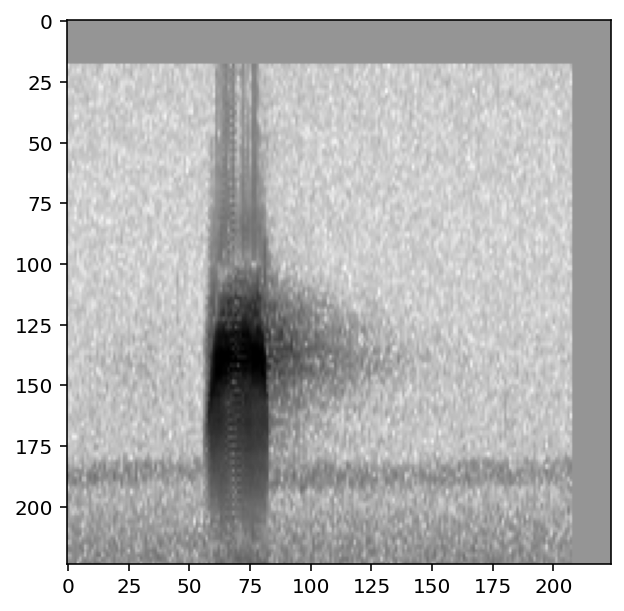

random affine off


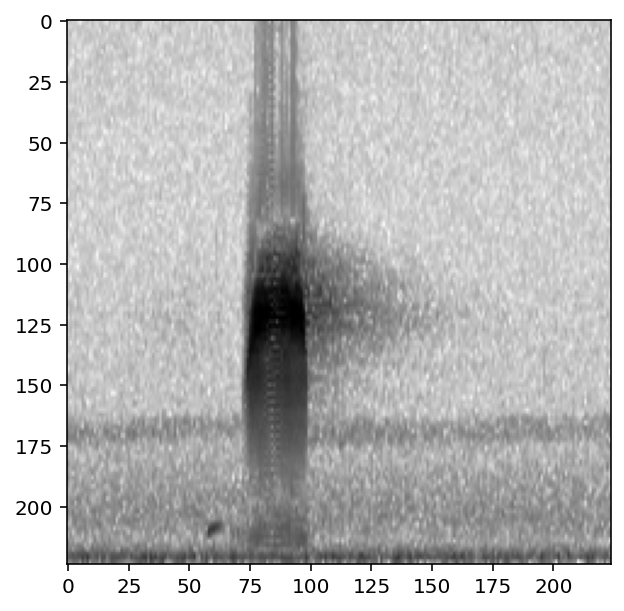

In [75]:
print('random affine on')
show_tensor(preprocessor[0])

print('random affine off')
preprocessor.actions.random_affine.off()
show_tensor(preprocessor[0])

To view whether an individual Action in a pipeline is on or off, inspect its `bypass` attribute:

In [76]:
# The AudioLoader Action that is still on
preprocessor.pipeline[0].bypass

False

In [77]:
# The TorchRandomAffine Action that we turned off
preprocessor.pipeline[-1].bypass

True

## Modifying the pipeline
Sometimes, you may want to change the order or composition of the Preprocessor's pipeline. You can simply overwrite the `.pipeline` attribute, as long as the new pipeline is still a list of Action instances from the preprocessor's `.actions` ActionContainer. 

### Example: return Spectrogram instead of Tensor
Here's an example where we replace the pipeline with one that just loads audio and converts it to a Spectrogram, returning a Spectrogram instead of a Tensor:

original pipeline:

new pipeline:

we now have a preprocessor that returns Spectrograms instead of Tensors:
<class 'opensoundscape.spectrogram.Spectrogram'>


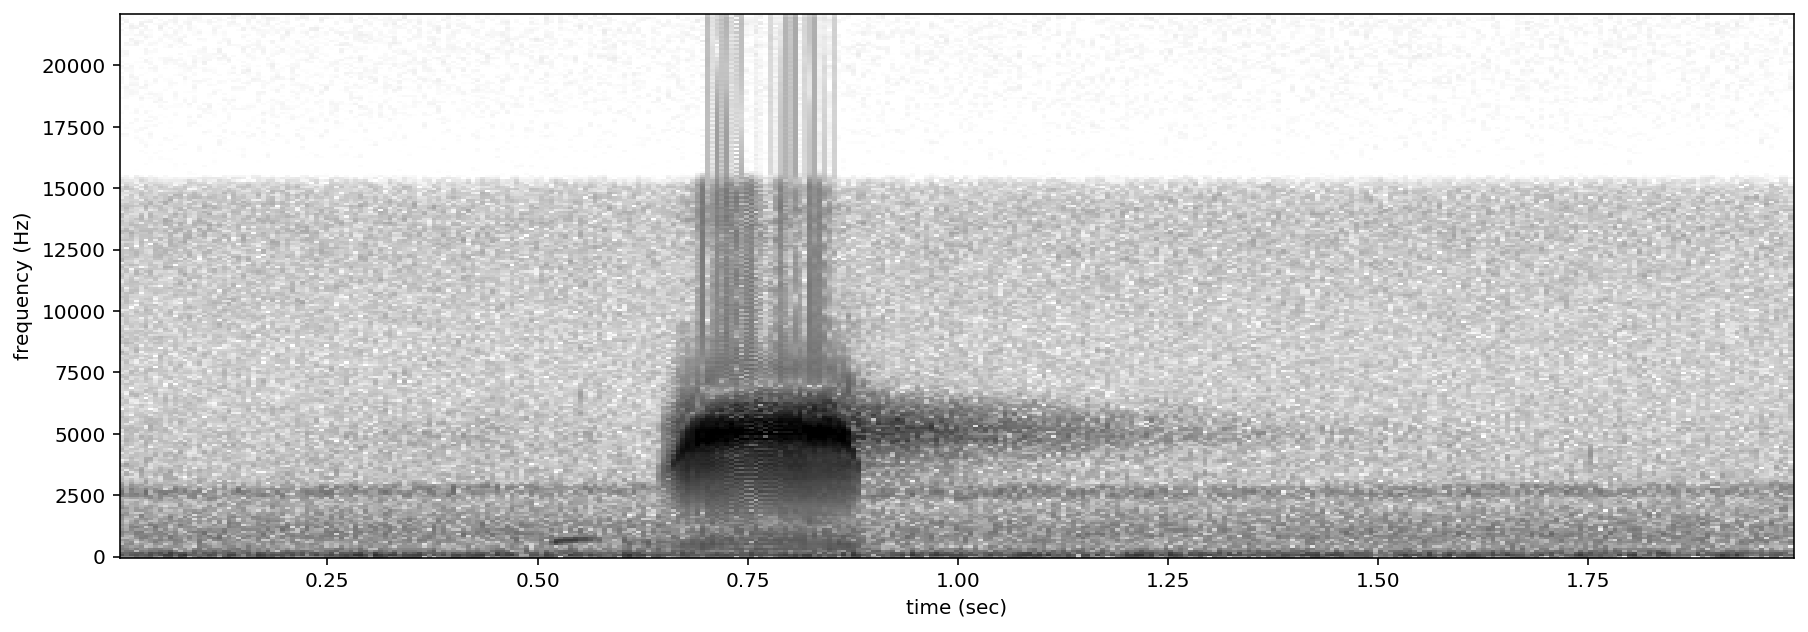

In [78]:
#initialize a preprocessor 
preprocessor = AudioToSpectrogramPreprocessor(labels)
print('original pipeline:')
[print(p) for p in preprocessor.pipeline]

#overwrite the pipeline with a slice of the original pipeline
print('\nnew pipeline:')
preprocessor.pipeline = preprocessor.pipeline[0:3]

[print(p) for p in preprocessor.pipeline]

print('\nwe now have a preprocessor that returns Spectrograms instead of Tensors:')
print(type(preprocessor[0]['X']))
preprocessor[0]['X'].plot()

### Example: custom augmentation pipeline
Here's an example where we add a new Action to the Action container, then overwrite the preprocessing pipeline with one that includes our new action. 

Note that each Action requires a specific input Type and may return that same Type or a different Type. So you'll need to be careful about the order of your Actions in your pipeline

This custom pipeline will first performs a Gaussian noise augmentation, then a random affine, then our second noise augmentation (add_noise_2)

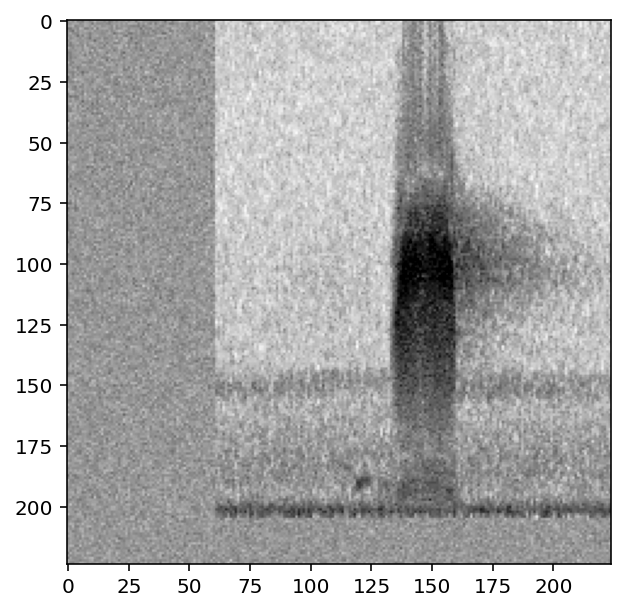

In [79]:
#initialize a preprocessor
preprocessor = CnnPreprocessor(labels)

#add a new Action to the Action container
from opensoundscape.preprocess.actions import TensorAddNoise
preprocessor.actions.add_noise_2 = TensorAddNoise(std=0.1)

#overwrite the pipeline with a list of Actions from .actions 
preprocessor.pipeline = [
    preprocessor.actions.load_audio,
    preprocessor.actions.trim_audio,
    preprocessor.actions.to_spec,
    preprocessor.actions.bandpass,
    preprocessor.actions.to_img,
    preprocessor.actions.to_tensor,
    preprocessor.actions.normalize,
    preprocessor.actions.add_noise,
    preprocessor.actions.random_affine,
    preprocessor.actions.add_noise_2
]

show_tensor(preprocessor[0])

### Use an Action multiple times in a pipeline

If an Action is present multiple times in a pipeline (e.g. multiple overlays), changing the parameters of the Action at one point in the pipeline will change it at all points in the pipeline. For instance, create a pipeline with multiple "add noise" steps:

In [80]:
#initialize a preprocessor that includes augmentation
preprocessor = CnnPreprocessor(labels)

# Insert another instance of the "add_noise" action into the pipeline
preprocessor.pipeline.insert(-2, preprocessor.actions.add_noise)
preprocessor.pipeline

Note that changing the parameter of one of the `add_noise` steps changes the parameters for both of them.

In [81]:
# Print the parameters of both of the TensorAddNoise Actions in the pipeline
print("Parameters of TensorAddNoise actions before changing:")
[print(f"Params of {p}:", p.params) for p in preprocessor.pipeline[-4:-2]]

# Change the parameters of one of the add noise steps
preprocessor.pipeline[-4].set(std=0.01)

# The modification above is the same as:
#preprocessor.actions.add_noise.set(std=0.01)

# See that the parameters for both steps are changed
print("\nParameters of TensorAddNoise actions after changing:")
[print(f"Params of {p}:", p.params) for p in preprocessor.pipeline[-4:-2]];

Parameters of TensorAddNoise actions before changing:
Params of <opensoundscape.preprocess.actions.TensorAddNoise object at 0x7fa99744fac0>: {'std': 0.005}
Params of <opensoundscape.preprocess.actions.TensorAddNoise object at 0x7fa99744fac0>: {'std': 0.005}

Parameters of TensorAddNoise actions after changing:
Params of <opensoundscape.preprocess.actions.TensorAddNoise object at 0x7fa99744fac0>: {'std': 0.01}
Params of <opensoundscape.preprocess.actions.TensorAddNoise object at 0x7fa99744fac0>: {'std': 0.01}


To modify the parameters of Actions individually, add them as separate Actions in the pipeline by adding a new named action to the action container.

In [82]:
from opensoundscape.preprocess.actions import TensorAddNoise

# Add a new possible action to the ActionContainer
preprocessor.actions.my_new_action = TensorAddNoise(std=0.005)

# Replace one of the old actions in the pipeline with the new one with different parameters
preprocessor.pipeline[-3] = preprocessor.actions.my_new_action

Now notice that the two instances of the `TensorAddNoise` action can have different parameters.

In [83]:
[print(f"Params of {p}:", p.params) for p in preprocessor.pipeline[-4:-2]];

Params of <opensoundscape.preprocess.actions.TensorAddNoise object at 0x7fa99744fac0>: {'std': 0.01}
Params of <opensoundscape.preprocess.actions.TensorAddNoise object at 0x7fa9974eed30>: {'std': 0.005}


## Customizing `AudioToSpectrogramPreprocessor`

Below are various examples of how to modify parameters of the Actions of the `AudioToSpectrogramPreprocessor` class, including the `AudioLoader`, `AudioToSpectrogram`, and `SpectrogramBandpass` actions.

### Modify the sample rate 
Re-sample all loaded audio to a specified rate during the load_audio action

In [84]:
preprocessor = AudioToSpectrogramPreprocessor(labels)

preprocessor.actions.load_audio.set(sample_rate=24000)

### Modify spectrogram window length and overlap
(see Spectrogram.from_audio() for detailed documentation)

default parameters:


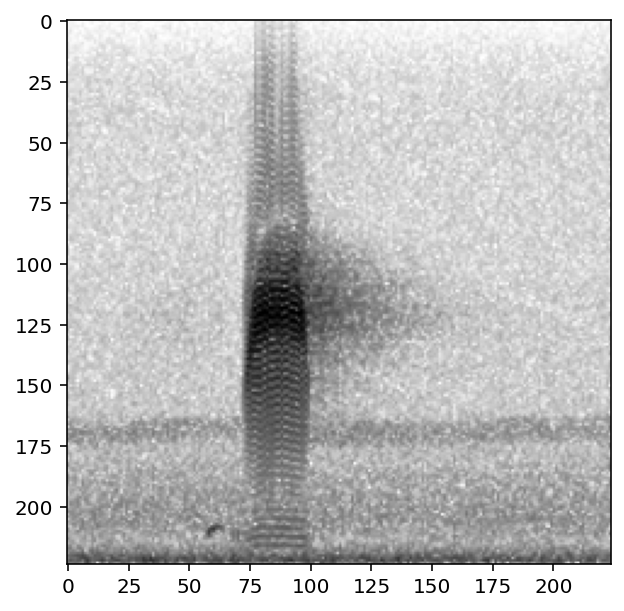

high time resolution, low frequency resolution:


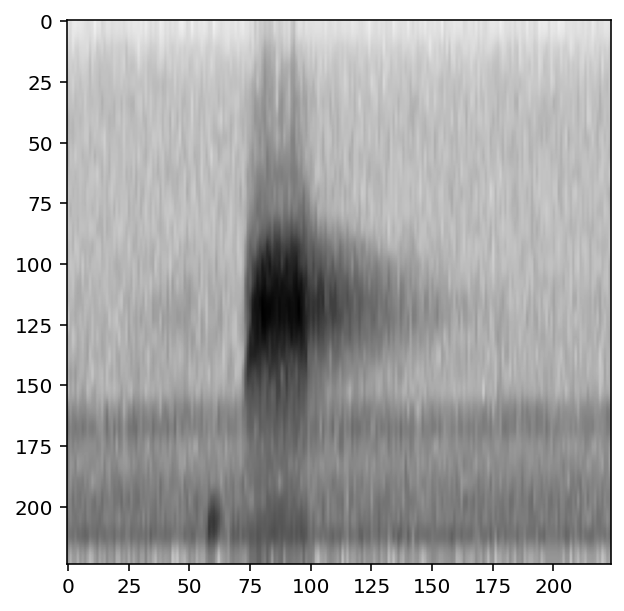

In [85]:
print('default parameters:')
show_tensor(preprocessor[0])

print('high time resolution, low frequency resolution:')
preprocessor.actions.to_spec.set(window_samples=64,overlap_samples=32)

show_tensor(preprocessor[0])

### Bandpass spectrograms
Trim spectrograms to a specified frequency range:

default parameters:


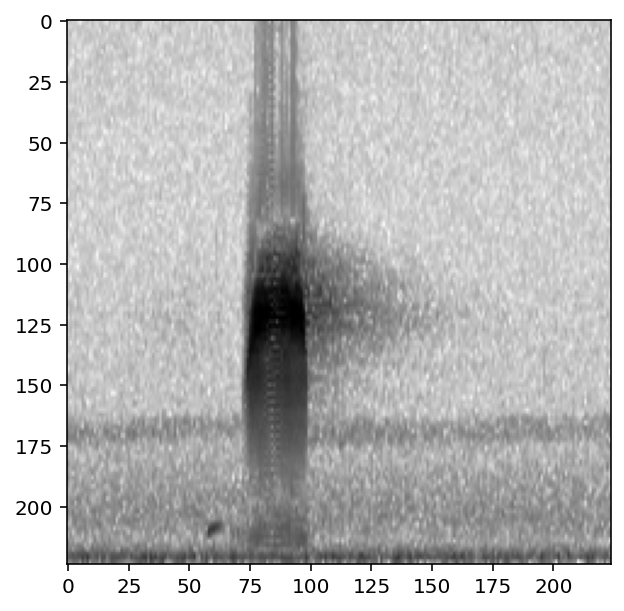

bandpassed to 2-4 kHz:


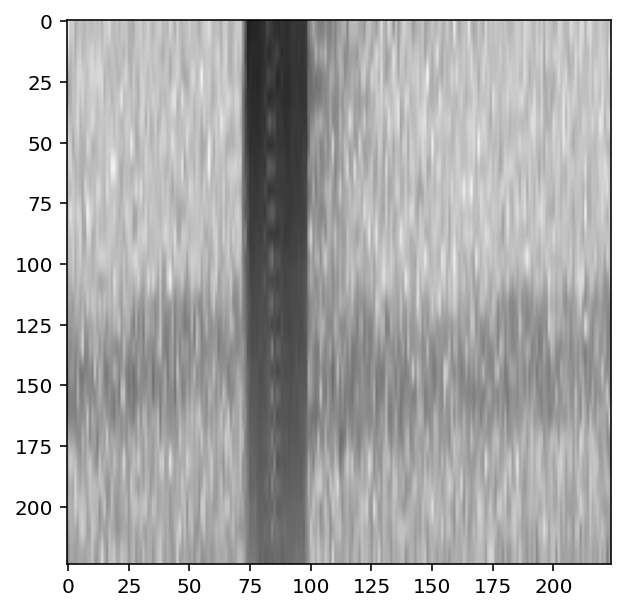

In [86]:
preprocessor = AudioToSpectrogramPreprocessor(labels)

print('default parameters:')
show_tensor(preprocessor[0])

print('bandpassed to 2-4 kHz:')
preprocessor.actions.bandpass.set(min_f=2000,max_f=4000)
preprocessor.actions.bandpass.on()
show_tensor(preprocessor[0])

### Change the output image

Change the shape of the output image 
- note that the shape argument expects (height, width), not (widht, height) 

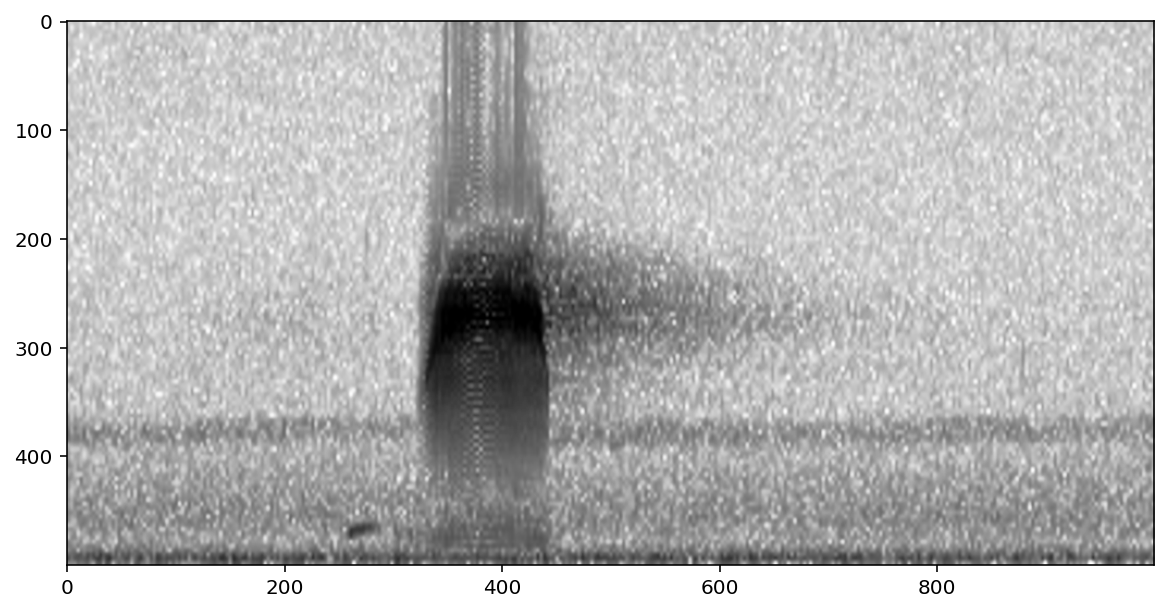

In [87]:
preprocessor = AudioToSpectrogramPreprocessor(labels)
preprocessor.actions.to_img.set(shape=[500,1000])
show_tensor(preprocessor[0])

## Customizing `CnnPreprocessor`

The `CnnPreprocessor` class can be used to perform both audio and spectrogram transformation as well as augmentation for training with CNNs.

This section describes:
* A special method of `CnnPreprocessor` which allows you to turn all augmentations on or off
* Examples of modifying augmentation parameters for standard augmentations
* Detailed descriptions of the useful "Overlay" augmentation

### Turn all augmentation on or off
With `CnnPreprocessor`, we can easily choose between a pipeline that contains augmentations and a pipeline with no augmentations using the shortcuts `augmentation_off()` and `augmentation_on()` methods. Using these methods will overwrite any changes made to the pipeline, so apply them first before further customizing an instance of `CnnPreprocessor`.

In [88]:
preprocessor = CnnPreprocessor(labels)
preprocessor.augmentation_off()
preprocessor.pipeline

In [89]:
preprocessor.augmentation_on()
preprocessor.pipeline

### Modify augmentation parameters
`CnnPreprocessor` includes several augmentations with customizable parameters. Here we provide a couple of illustrative examples - see any action's documentation for details on how to use its parameters. 

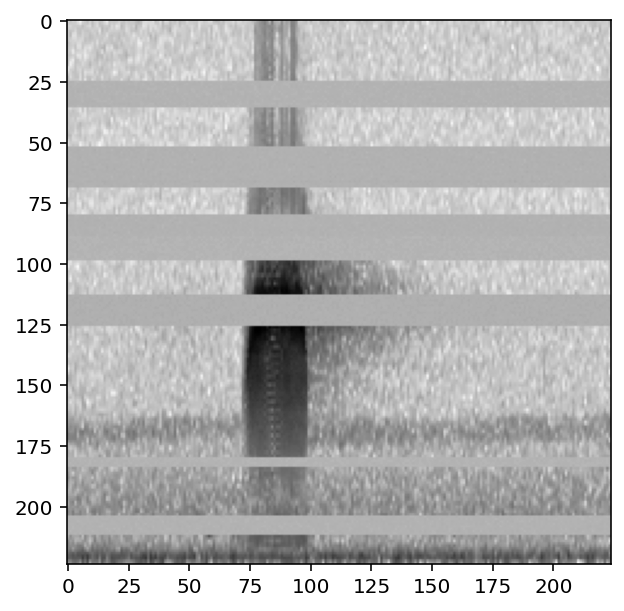

In [90]:
#initialize a preprocessor
preprocessor = CnnPreprocessor(labels)

#turn off augmentations other than overlay
preprocessor.actions.color_jitter.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.time_mask.off()

# allow up to 20 horizontal masks, each spanning up to 0.1x the height of the image. 
preprocessor.actions.frequency_mask.set(max_width = 0.1, max_masks=20)
show_tensor(preprocessor[0])

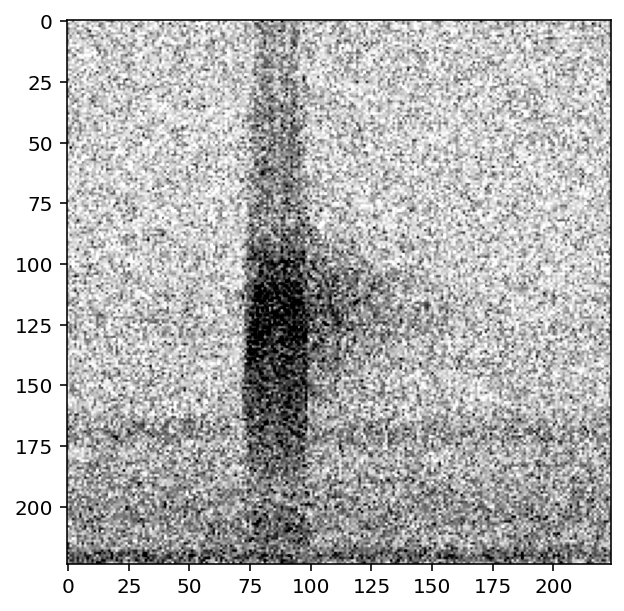

In [91]:
#turn off frequency mask and turn on gaussian noise
preprocessor.actions.add_noise.on()
preprocessor.actions.frequency_mask.off()

# increase the intensity of gaussian noise added to the image
preprocessor.actions.add_noise.set(std=0.2)
show_tensor(preprocessor[0])

### Overlay augmentation
Overlay is a powerful Action that allows additional samples to be overlayed or blended with the original sample. 

The additional samples are chosen from the `overlay_df` that is provided to the preprocessor when it is initialized. The index of the `overlay_df` must be paths to audio files. The dataframe can be simply an index containing audio files with no other columns, or it can have the same columns as the sample dataframe for the preprocessor.

Samples for overlays are chosen based on their class labels, according to the parameter `overlay_class`:

- `None` - Randomly select any file from `overlay_df`
- `"different"` - Select a random file from `overlay_df` containing none of the classes this file contains
- specific class name - always choose files from this class

Samples can be drawn from dataframes in a few general ways (each is demonstrated below):

1. Using a separate dataframe where any sample can be overlayed (`overlay_class=None`)
2. Using the same dataframe as training, where the overlay class is "different," i.e., does not contain overlapping labels with the original sample
3. Using the same dataframe as training, where samples from a specific class are used for overlays

By default, the overlay Action does **not** change the labels of the sample it modifies. However, if you wish to add the labels from overlayed samples to the original sample's labels, you can set `update_labels=True` (see example below).

In [92]:
#initialize a preprocessor and provide a dataframe with samples to use as overlays
preprocessor = CnnPreprocessor(labels, overlay_df=labels)

#turn off augmentations other than overlay
preprocessor.actions.color_jitter.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.time_mask.off()
preprocessor.actions.frequency_mask.off()

#### Modify `overlay_weight`
We'll first overlay a random sample with 30% of the final mix coming from the overlayed sample (70% coming from the original) by using `overlay_weight=0.3`.

To demonstrate this, let's show what happens if we overlay samples from the "negative" class, resulting in the final sample having a higher or lower signal-to-noise ratio. By default, the overlay Action chooses a random file from the overlay dataframe. Instead, choose a sample from the class called `"absent"` using the `overlay_class` parameter. 

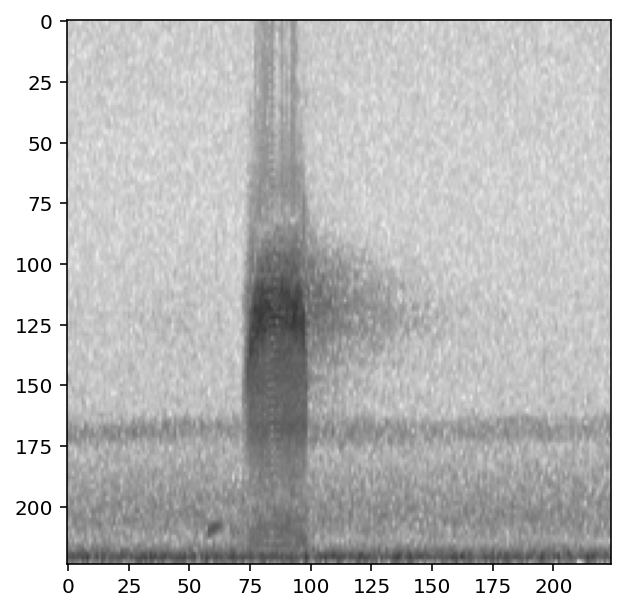

In [93]:
preprocessor.actions.overlay.set(
    overlay_class='absent',
    overlay_weight=0.3
)
show_tensor(preprocessor[0])

Now use `overlay_weight=0.8` to increase the contribution of the overlayed sample (80%) compared to the original sample (20%). 

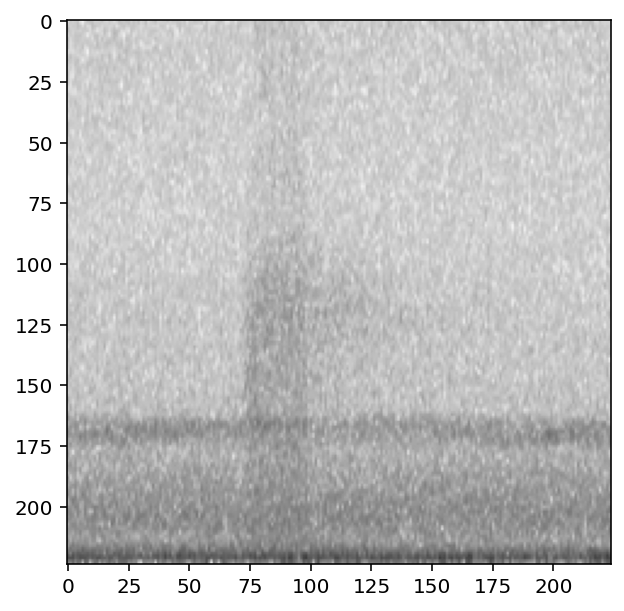

In [94]:
preprocessor.actions.overlay.set(overlay_weight=0.8)
show_tensor(preprocessor[0])

#### Overlay samples from a specific class

As demonstrated above, you can choose a specific class to choose samples from. Here, instead, we choose samples from the "positive" class.

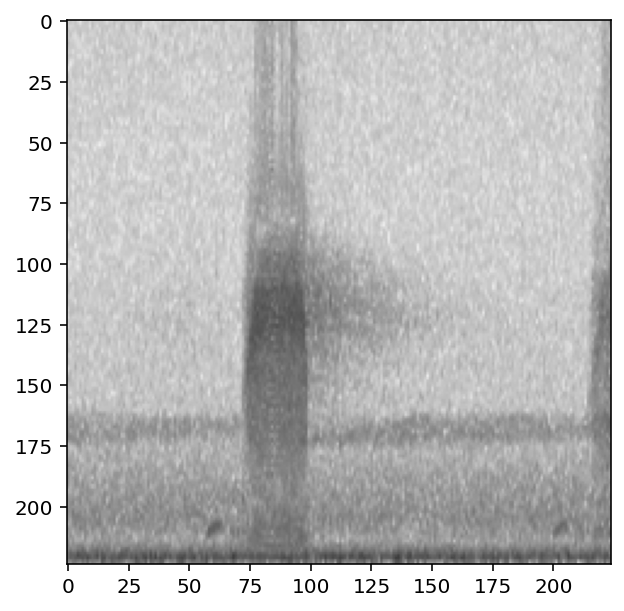

In [95]:
preprocessor.actions.overlay.set(
    overlay_class='present',
    overlay_weight=0.4
)
show_tensor(preprocessor[0])

#### Overlaying samples from any class
By default, or by specifying `overlay_class=None`, the overlay sample is chosen randomly from the overlay_df with no restrictions

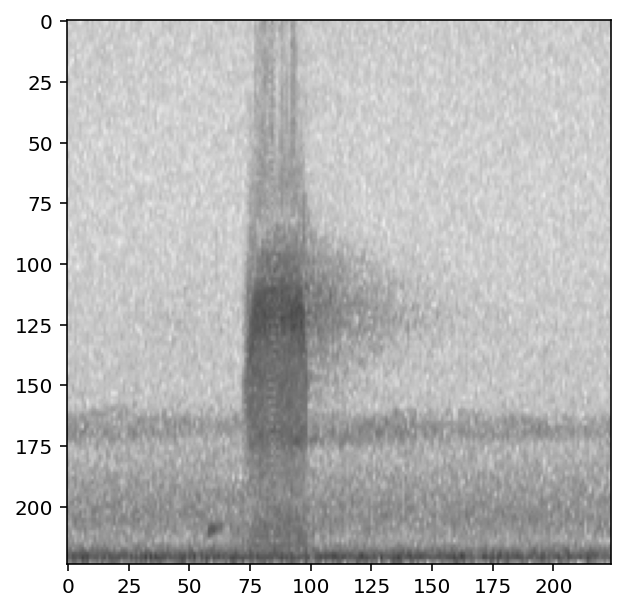

In [96]:
preprocessor.actions.overlay.set(overlay_class=None)
show_tensor(preprocessor[0])

#### Overlaying samples from a "different" class
The `'different'` option for `overlay_class` chooses a sample to overlay that has non-overlapping labels with the original sample. 

In the case of this example, this has the same effect as drawing samples from the `"negative"` class a demonstrated above. In multi-class examples, this would draw from any of the samples not labeled with the class(es) of the original sample.

We'll again use `overlay_weight=0.8` to exaggerate the importance of the overlayed sample (80%) compared to the original sample (20%). 

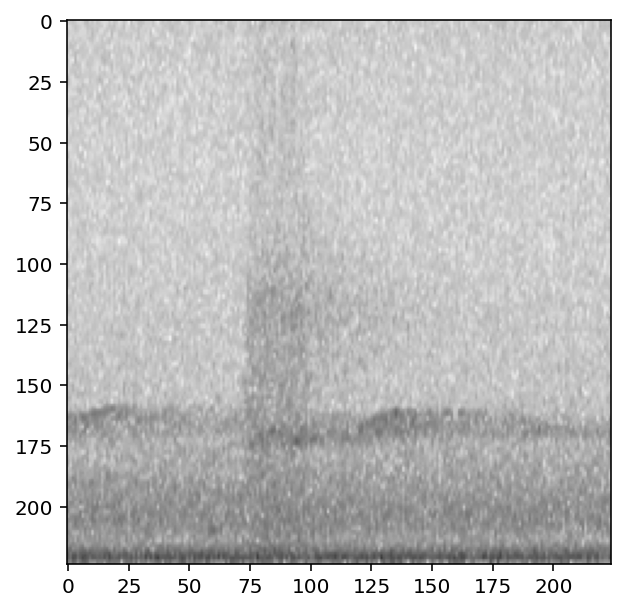

In [97]:
preprocessor.actions.overlay.set(update_labels=False,overlay_class='different',overlay_weight=0.8)
show_tensor(preprocessor[0])

#### Updating labels 
By default, the overlay Action does **not** change the labels of the sample it modifies. 

For instance, if the overlayed sample has labels [1,0] and the original sample has labels [0,1], the default behavior will return a sample with labels [0,1] not [1,1]. 

If you wish to add the labels from overlayed samples to the original sample's labels, you can set `update_labels=True`. 

In [98]:
print('default: labels do not update')
preprocessor.actions.overlay.set(update_labels=False,overlay_class='different')
print(f"\t resulting labels: {preprocessor[0]['y'].numpy()}")

print('Using update_labels=True')
preprocessor.actions.overlay.set(update_labels=True,overlay_class='different')
print(f"\t resulting labels: {preprocessor[0]['y'].numpy()}")


default: labels do not update
	 resulting labels: [1 0]
Using update_labels=True
	 resulting labels: [1 1]


This example is a single-target problem: the two classes represent "woodcock absent" and "woodcock present." Because the labels are mutually exclusive, labels [1,1] do not make sense. So, for this single-target problem, we would not want to use `update_labels=True`, and it would probably make most sense to only overlay absent recordings, e.g., `overlay_class='absent'`.

## Creating a new Preprocessor class
If you have a specific augmentation routine you want to perform, you may want to create your own Preprocessor class rather than modifying an existing one. 


Your subclass might add a different set of Actions, define a different pipeline, or even override the `__getitem__` method of BasePreprocessor. 

Here's an example of a customized preprocessor that subclasses `AudioToSpectrogramPreprocessor` and creates a pipeline that depends on the `magic_parameter` input. 

In [99]:
from opensoundscape.preprocess.actions import TensorAddNoise
class MyPreprocessor(AudioToSpectrogramPreprocessor):
    """Child of AudioToSpectrogramPreprocessor with weird augmentation routine"""
    
    def __init__(
        self,
        df,
        magic_parameter,
        audio_length=None,
        return_labels=True,
        out_shape=[224, 224],
    ):

        super(MyPreprocessor, self).__init__(
            df,
            audio_length=audio_length,
            out_shape=out_shape,
            return_labels=return_labels,
        )

        self.actions.add_noise = TensorAddNoise(std=0.1*magic_parameter)

        self.pipeline = [
            self.actions.load_audio,
            self.actions.trim_audio,
            self.actions.to_spec,
            self.actions.bandpass,
            self.actions.to_img,
            self.actions.to_tensor,
            self.actions.normalize,
        ] + [self.actions.add_noise for i in range(magic_parameter)]

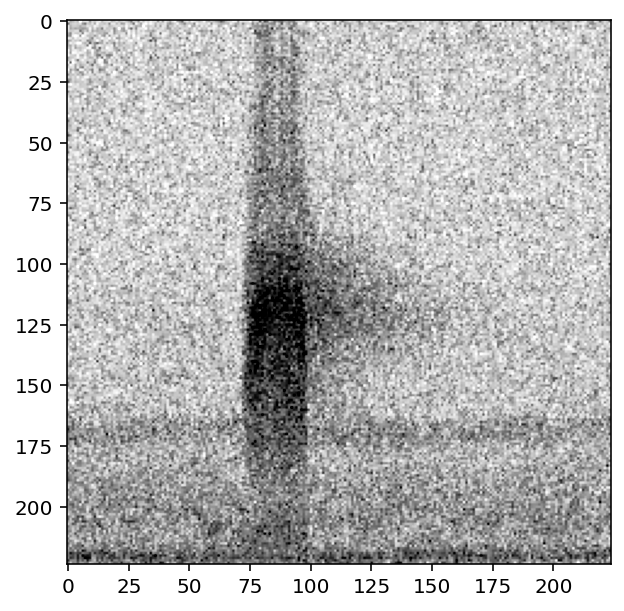

In [100]:
p = MyPreprocessor(labels, magic_parameter=2)
show_tensor(p[0])

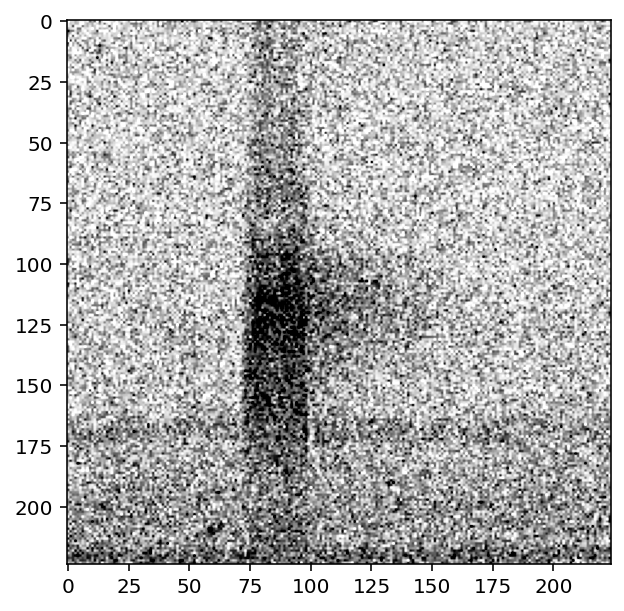

In [101]:
p = MyPreprocessor(labels, magic_parameter=3)
show_tensor(p[0])

## Defining new Actions
You can define new Actions to include in your Preprocessor pipeline. They should subclass `opensoundscape.actions.BaseAction`. 

You will need to define a `.go()` method for all actions. If you provide default parameter values, you will also need to define an `__init__()` method.

### Without default parameters
If the Action does not need to have default arguments, it's trivial to create by defining a `go()` method.

In [102]:
from opensoundscape.preprocess.actions import BaseAction
class SquareSamples(BaseAction):
    """Square values of every audio sample
    
    Audio in, Audio out
    """
    def go(self, audio):
        samples = np.array(audio.samples)**2
        return Audio(samples, audio.sample_rate)

Test it out:

In [103]:
from opensoundscape.audio import Audio

square_action = SquareSamples(threshold=0.2)

audio = Audio.from_file('./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav')
print(np.mean(audio.samples))
audio = square_action.go(audio)
print(np.mean(audio.samples))

0.012753859
0.008748752


### With default parameters
Here we overwrite the `__init__` method to provide a default parameter value. The Action below removes low-amplitude audio samples, acting somewhat as a "denoiser".

In [104]:
class AudioGate(BaseAction):
    """Replace audio samples below a threshold with 0
    
    Audio in, Audio out
    
    Args: 
        threshold: sample values below this will become 0
    """

    def __init__(self, **kwargs):
        super(AudioGate, self).__init__(**kwargs)
        
        # default parameters
        self.params["threshold"] = 0.1
        
        # update/add any parameters passed to __init__
        self.params.update(kwargs)
    
    def go(self, audio):
        samples = np.array([0 if np.abs(s)<self.params["threshold"] else s for s in audio.samples])
        return Audio(samples, audio.sample_rate)

Test it out:

histogram of samples


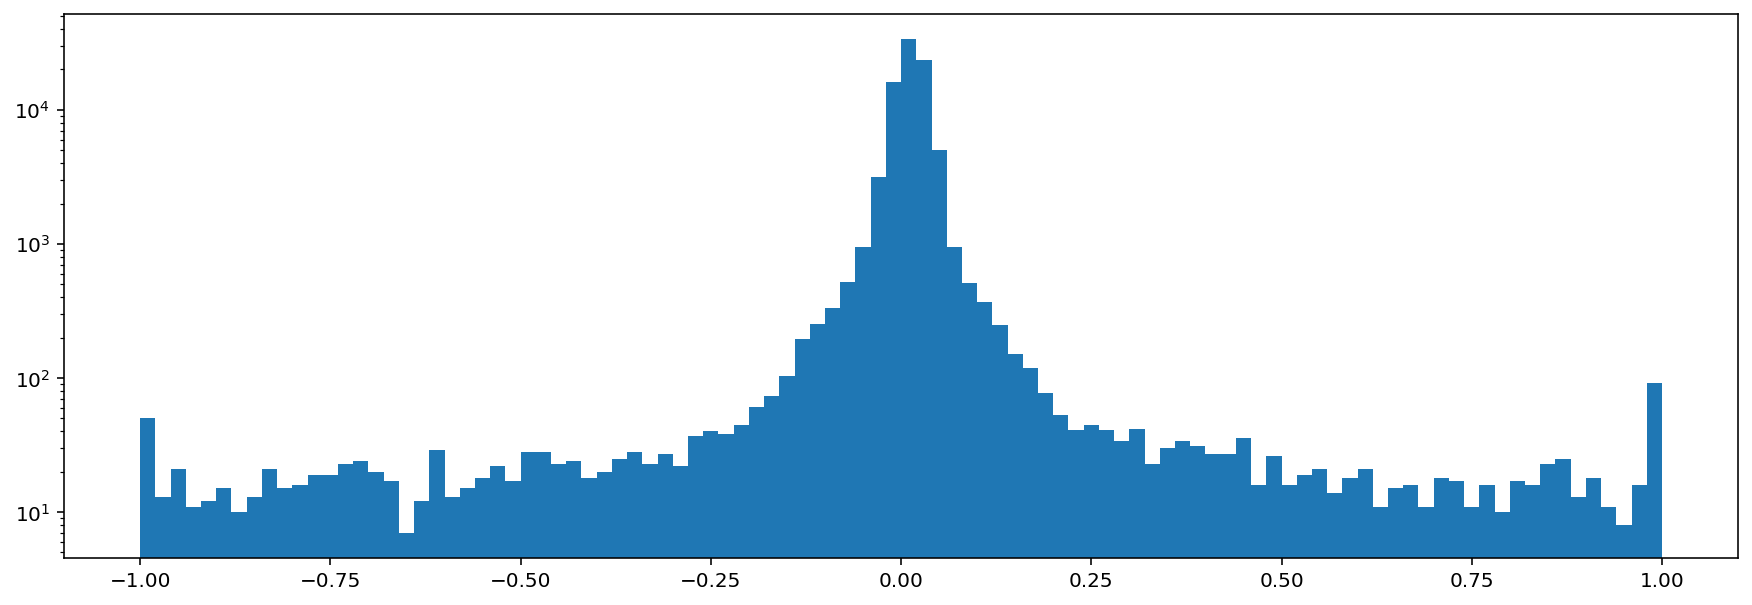

histogram of samples after audio gate


[]

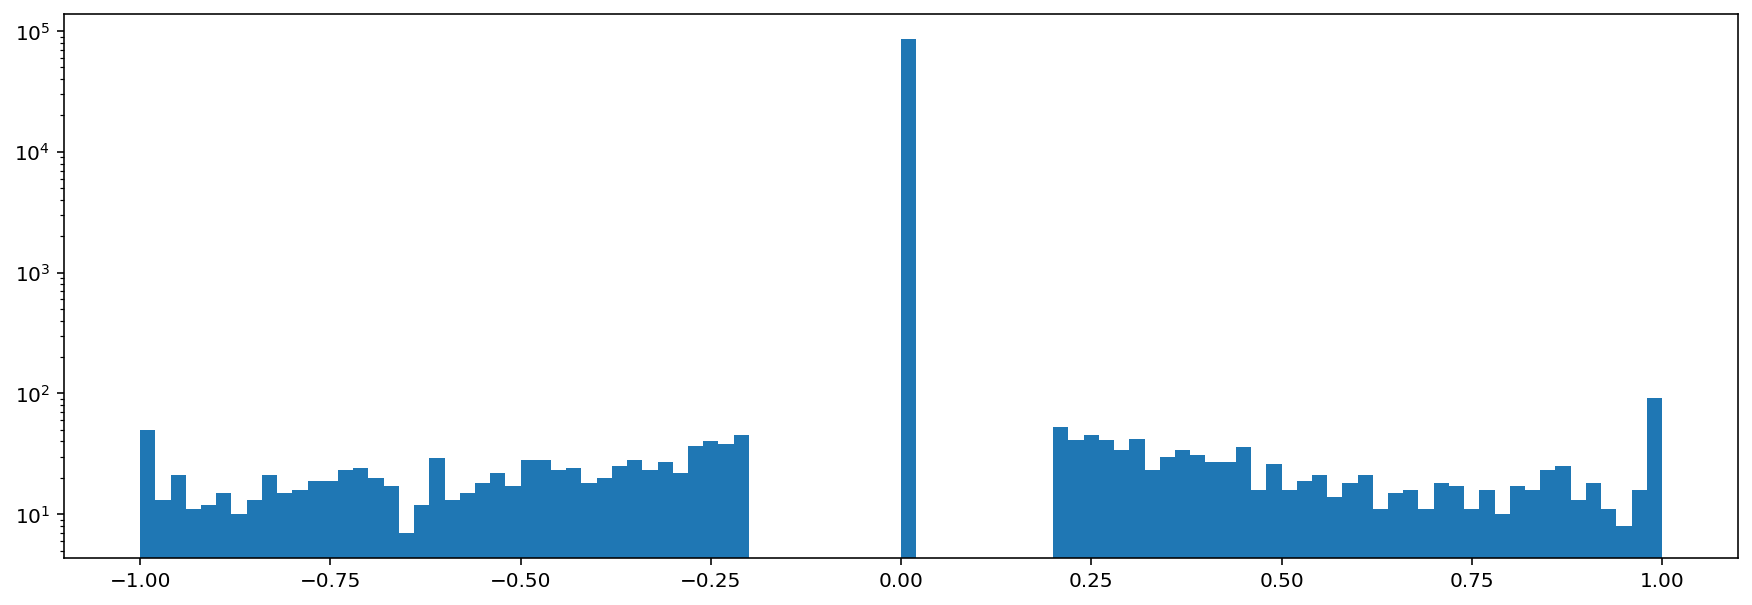

In [105]:
gate_action = AudioGate(threshold=0.2)

print('histogram of samples')
audio = Audio.from_file('./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav')
_ = plt.hist(audio.samples,bins=100)
plt.semilogy()
plt.show()

print('histogram of samples after audio gate')
audio_gated = gate_action.go(audio)
_ = plt.hist(audio_gated.samples,bins=100)
plt.semilogy()

Clean up files created during this tutorial:

In [106]:
import shutil
shutil.rmtree('./woodcock_labeled_data')